# Synopsis

This analysis is based on the Sean Lahman's database, which contains complete batting and pitching statistics from 1871 to 2015, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. In this project, I'll try to answer the following questions:
1. Do players who get higher salary tend to play more total games in a season? 
2. For players who play more than 100 batting, does more homeruns mean more strikeouts?
3. Do players using left throwing hand have higher winning percentage than right throwing hand?

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Do players who get higher salary tend to play more games in a season?

### Import the data

In [2]:
salary = pd.read_csv("baseballdatabank-master/core/Salaries.csv")

appear = pd.read_csv("baseballdatabank-master/core/Appearances.csv", usecols=["yearID","teamID","lgID","playerID", "G_all"])

First, check the salary change over the years

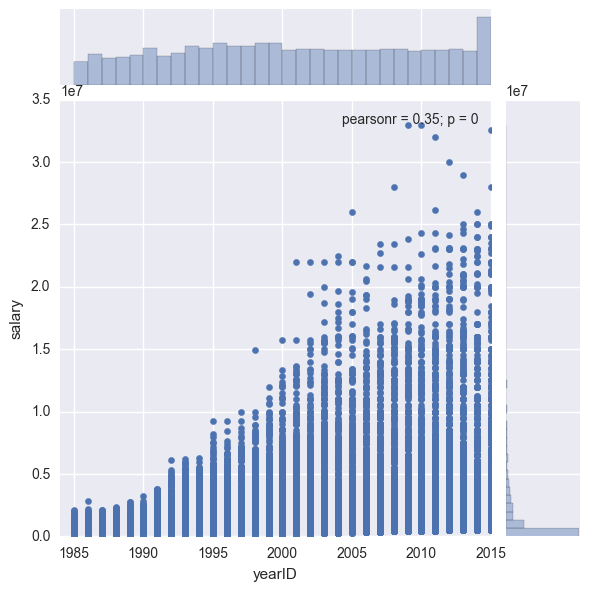

In [3]:
sns.jointplot("yearID", "salary", data=salary, xlim=(1984, 2015), ylim=(0, 3.5e7))

There's a clear trend that players are getting more salary over the years. To study the relationship between salary and total played games, I'll only use the recent data in 2015 to exclude this effect.

### Data wrangling 

Select the data in 2015

In [4]:
salary2015 = salary[salary["yearID"]==2015]
appear2015 = appear[appear["yearID"]==2015]

Merge the two tables

In [5]:
appear_salary =  appear2015.merge(salary2015, on=['yearID','teamID','lgID','playerID'], how = 'inner')

In [6]:
appear_salary.describe()

,yearID,G_all,salary
count,810.0,810.000000,8.100000e+02
mean,2015.0,67.176543,4.295658e+06
std,0.0,47.896001,5.513213e+06
min,2015.0,1.000000,5.070000e+05
25%,2015.0,29.000000,5.225000e+05
50%,2015.0,55.000000,1.865000e+06
75%,2015.0,106.000000,5.862500e+06
max,2015.0,162.000000,3.257100e+07


In [7]:
sum(appear_salary["G_all"].isnull()) | sum(appear_salary["salary"].isnull())

0

In the selected dataset, no missing values for salary or total games played has been found.

### Exploration

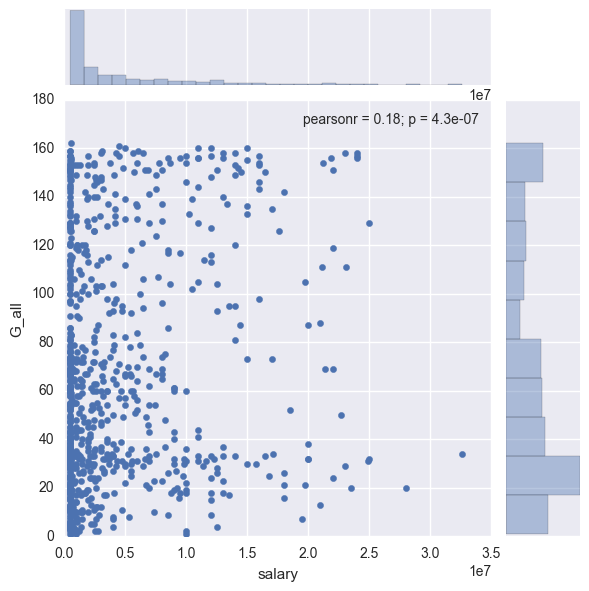

In [15]:
sns.jointplot("salary", "G_all", data=appear_salary, xlim=(0, 3.5e7), ylim=(0,180))

 The correlation coefficient given by Pearson method is 0.18, which indicates a weak positive correlation between salary and total games played. I also check the correlation using the Spearman method, and it shows similar result:

In [126]:
appear_salary['G_all'].corr(appear_salary['salary'], method ='spearman')

0.17926230528570331

## Conclusion

The data in 2015 show a positive but weak correlation between salary and total games played. Correlation does not imply causation. It's likely that the player with higher salary has better skills or healthy body, which explain for the more games played in a season. Also, only data in 2015 is used as an example, which might not be representative.

# 2. For players who play more than 100 batting, does more homeruns mean more strikeouts?

If a batter is going for the fences with many home runs in a season, is he also going to strikeout a lot? This section will try to explore the relationship between homeruns rates and strikeouts rates. 

### Import data with relevant columns

In [27]:
batting = pd.read_csv("baseballdatabank-master/core/Batting.csv", usecols=["playerID","teamID","G","HR","SO"])

In [31]:
batting.head()

,playerID,teamID,G,HR,SO
0,abercda01,TRO,1,0.0,0.0
1,addybo01,RC1,25,0.0,0.0
2,allisar01,CL1,29,0.0,5.0
3,allisdo01,WS3,27,2.0,2.0
4,ansonca01,RC1,25,0.0,1.0


In the data, G is number of games, HR is number of homeruns, SO is the number of strikeouts. 

### Data wrangling 

There are missing points in the data. We'll delete any item with missing data.

In [41]:
batting_dropna = batting.dropna()

Then the data are summed by the player.

In [39]:
batting_player = batting_dropna.groupby(['playerID']).sum()

Then, we retain the data with players playing more than 100 games in the batting, and calculate the homeruns rate and strikeouts rate for the player. 

In [65]:
batting_player = batting_player[batting_player["G"]>=100]

In [66]:
batting_player["HR/G"] = batting_player["HR"]/batting_player["G"]
batting_player["SO/G"] = batting_player["SO"]/batting_player["G"]

In [80]:
batting_player.describe()

,G,HR,SO,HR/G,SO/G
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,572.055121,35.191129,235.365979,0.037608,0.370735
std,531.850203,72.579451,300.946043,0.046357,0.230637
min,101.000000,0.000000,0.000000,0.000000,0.000000
25%,194.000000,0.000000,48.000000,0.000000,0.210602
50%,360.000000,6.000000,122.000000,0.019417,0.348718
75%,758.000000,32.000000,294.000000,0.057377,0.512605
max,3562.000000,762.000000,2597.000000,0.311099,1.324561


### Exploration

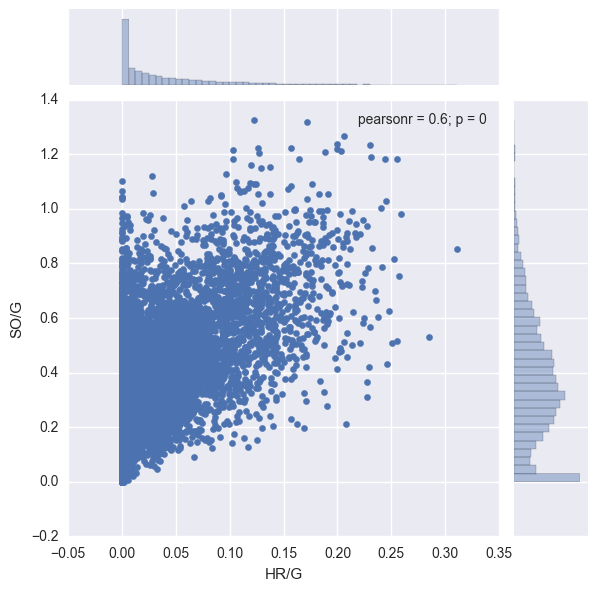

In [68]:
sns.jointplot("HR/G", "SO/G", data=batting_player)

From the plot, the HR and SO shows a positive correlation, with Pearson correlation coefficient 0.6. Also checking with Spearman method:

In [78]:
batting_player["HR/G"].corr(batting_player["SO/G"], method = 'spearman')

0.62041075471198814

 ## Conclusion

The data show a positive correlation between homeruns rate and strikeouts rate for players who play more than 100 batting, which indicates players with more homeruns tends to have more strikeouts. However, correlation does not imply causation. Many other factors, such as the players' weight, skill, game strategy may contribute. 

# 3. Do players using left throwing hand have higher winning percentage than right throwing hand?

### Import data with relevant columns 

In [3]:
master = pd.read_csv("baseballdatabank-master/core/Master.csv", usecols=["playerID","throws"])
pitch = pd.read_csv("baseballdatabank-master/core/Pitching.csv", usecols=["playerID","teamID","W","L"])

In [4]:
master.head()

,playerID,throws
0,aardsda01,R
1,aaronha01,R
2,aaronto01,R
3,aasedo01,R
4,abadan01,L


"throws" represent for Player's throwing hand (left or right)

In [5]:
pitch.tail(10)

,playerID,teamID,W,L
44129,wrighmi01,BAL,3,5
44130,wrighst01,BOS,5,4
44131,wrighwe01,BAL,0,0
44132,wrighwe01,LAA,0,0
44133,yateski01,TBA,1,0
44134,youngch03,KCA,11,6
44135,zieglbr01,ARI,0,3
44136,zimmejo02,WAS,13,10
44137,zitoba01,OAK,0,0
44138,zychto01,SEA,0,0


W, L represents for win and losses, respectively

### Data wrangling

Drop the item with missing values

In [6]:
master_dropna = master.dropna()
pitch_dropna  = pitch.dropna()

Merge the two tables on playerID

In [7]:
pitch_hand =  master_dropna.merge(pitch_dropna, on=['playerID'], how = 'inner')

In [8]:
pitch_hand.head()

,playerID,throws,teamID,W,L
0,aardsda01,R,SFN,1,0
1,aardsda01,R,CHN,3,0
2,aardsda01,R,CHA,2,1
3,aardsda01,R,BOS,4,2
4,aardsda01,R,SEA,3,6


The data is divided into left throwing hand and right throwing hand: 

In [9]:
pitching_player_L0 = pitch_hand[pitch_hand["throws"]=="L"]
pitching_player_R0 = pitch_hand[pitch_hand["throws"]=="R"]

Each item represent the player statistics in one season. For each player, add up the win/loss statistics in different seasons and calculate the winning percentage. The winning percentage is defined as W/(W+L).

In [38]:
def win_percent(pitch_hand):
    pitch_player = pitch_hand.groupby(['playerID']).sum()
    win_and_loss = pitch_player["W"]+pitch_player["L"]
    # Players with W+L less than 10 are excluded.
    pitch_player_n0 =  pitch_player[win_and_loss>=10]
    # winning percentage
    pitch_player_n0.loc[:,"win%"] = 100*pitch_player_n0.loc[:,"W"]/win_and_loss
    return pitch_player_n0

Implement the function on two subsets

In [39]:
pitching_player_L = win_percent(pitching_player_L0)
pitching_player_R = win_percent(pitching_player_R0)

### Exploration

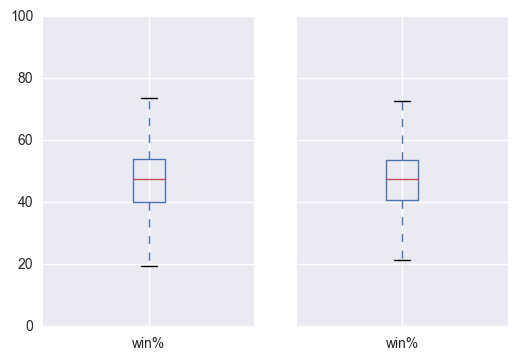

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
pitching_player_L.boxplot(column="win%", return_type='axes', ax = ax1)
pitching_player_R.boxplot(column="win%", return_type='axes', ax = ax2)

The left plot is the winning percentage for players with left throwing hand and the right plot for players with right throwing hand. There is no obvius difference between them.

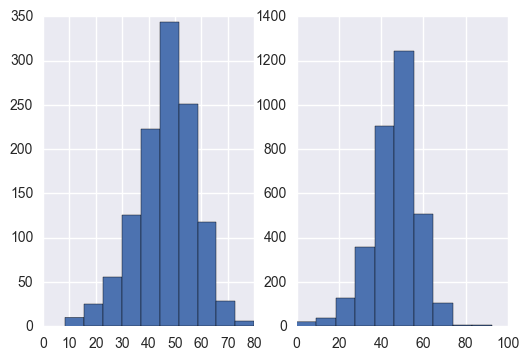

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
pitching_player_L["win%"].hist(ax = ax1)
pitching_player_R["win%"].hist(ax = ax2)

From above plots, the winning percentage is not exact nominal distribution for left/right throwing hand players. So the Mann–Whitney U test will be used. The null hypothesis is that the population winning percentage is EQUAL for left/right throwing hand players. And the alternative hypothesis is that population winning percentage is DIFFERENT for left/right throwing hand players.

In [55]:
stats.mannwhitneyu(pitching_player_L["win%"], pitching_player_R["win%"])

MannwhitneyuResult(statistic=1952335.5, pvalue=0.34136212328667637)

From the p value 0.34, we cannot reject the null hypothesis that population winning percentage is EQUAL for left/right throwing hand players at 95% confidence level.

## Conclusion

From the dataset we use, there is no obvious difference in the winning percentage between players using left throwing hand and players using right throwing hand.